In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

DATA_BASE_PATH = "./malimg_paper_dataset_imgs/"

In [8]:
# compute the class distribution
dist = {}
for mlw_class in os.listdir(DATA_BASE_PATH):
    mlw_dir = os.path.join(DATA_BASE_PATH, mlw_class)
    dist[mlw_class] = len(os.listdir(mlw_dir))

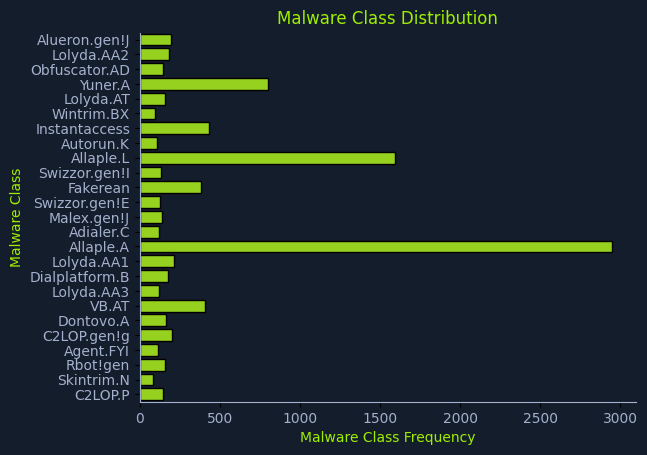

In [9]:
# plot the class distribution

# HTB Color Palette
htb_green = "#9FEF00"
node_black = "#141D2B"
hacker_grey = "#A4B1CD"

# data
classes = list(dist.keys())
frequencies = list(dist.values())

# plot
plt.figure(facecolor=node_black)
sns.barplot(y=classes, x=frequencies, edgecolor = "black", orient='h', color=htb_green)
plt.title("Malware Class Distribution", color=htb_green)
plt.xlabel("Malware Class Frequency", color=htb_green)
plt.ylabel("Malware Class", color=htb_green)
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
ax = plt.gca()
ax.set_facecolor(node_black)
ax.spines['bottom'].set_color(hacker_grey)
ax.spines['top'].set_color(node_black)
ax.spines['right'].set_color(node_black)
ax.spines['left'].set_color(hacker_grey)
plt.show()

In [10]:
from torchvision import transforms

# Define preprocessing transforms
transform = transforms.Compose([
	transforms.Resize((75, 75)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
from torchvision.datasets import ImageFolder
import os

BASE_PATH = "./newdata/"

# Load training and test datasets
train_dataset = ImageFolder(
	root=os.path.join(BASE_PATH, "train"),
    transform=transform
)

test_dataset = ImageFolder(
	root=os.path.join(BASE_PATH, "test"),
    transform=transform
)

In [12]:
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Create data loaders
train_loader = DataLoader(
    train_dataset,
	batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
    
test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9428324].


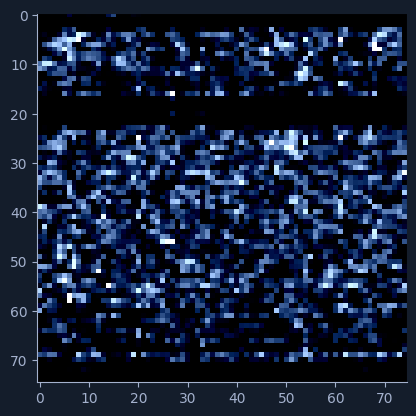

In [13]:
import matplotlib.pyplot as plt

# HTB Color Palette
htb_green = "#9FEF00"
node_black = "#141D2B"
hacker_grey = "#A4B1CD"

# image
sample = next(iter(train_loader))[0][0]

# plot
plt.figure(facecolor=node_black)
plt.imshow(sample.permute(1,2,0))
plt.xticks(color=hacker_grey)
plt.yticks(color=hacker_grey)
ax = plt.gca()
ax.set_facecolor(node_black)
ax.spines['bottom'].set_color(hacker_grey)
ax.spines['top'].set_color(node_black)
ax.spines['right'].set_color(node_black)
ax.spines['left'].set_color(hacker_grey)
ax.tick_params(axis='x', colors=hacker_grey)
ax.tick_params(axis='y', colors=hacker_grey)
plt.show()

In [14]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

def load_datasets(base_path, train_batch_size, test_batch_size):
    # Define preprocessing transforms
    transform = transforms.Compose([
        transforms.Resize((75, 75)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load training and test datasets
    train_dataset = ImageFolder(
        root=os.path.join(base_path, "train"),
        transform=transform
    )

    test_dataset = ImageFolder(
        root=os.path.join(base_path, "test"),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )

    n_classes = len(train_dataset.classes)
    return train_loader, test_loader, n_classes

In [15]:
import torch.nn as nn
import torchvision.models as models

HIDDEN_LAYER_SIZE = 1000

class MalwareClassifier(nn.Module):
    def __init__(self, n_classes):
        super(MalwareClassifier, self).__init__()
        # Load pretrained ResNet50
        self.resnet = models.resnet50(weights='DEFAULT')
        
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the last fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, HIDDEN_LAYER_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_SIZE, n_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [16]:
model = MalwareClassifier(25)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/zannic/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|███████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


In [17]:
DATA_PATH = "./newdata/"
TRAINING_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Load datasets
train_loader, test_loader, n_classes = load_datasets(DATA_PATH, TRAINING_BATCH_SIZE, TEST_BATCH_SIZE)

# Initialize model
model = MalwareClassifier(n_classes)

In [18]:
import torch
import time

def train(model, train_loader, n_epochs, verbose=False):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    training_data = {"accuracy": [], "loss": []}
    
    for epoch in range(n_epochs):
        running_loss = 0
        n_total = 0
        n_correct = 0
        checkpoint = time.time() * 1000
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            n_total += labels.size(0)
            n_correct += predicted.eq(labels).sum().item()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_duration = int(time.time() * 1000 - checkpoint)
        epoch_accuracy = compute_accuracy(n_correct, n_total)
        
        training_data["accuracy"].append(epoch_accuracy)
        training_data["loss"].append(epoch_loss)
        
        if verbose:
            print(f"[i] Epoch {epoch+1} of {n_epochs}: Acc: {epoch_accuracy:.2f}% Loss: {epoch_loss:.4f} (Took {epoch_duration} ms).")    
    
    return training_data

In [19]:
def save_model(model, path):
	model_scripted = torch.jit.script(model)
	model_scripted.save(path)

In [20]:
def predict(model, test_data):
    model.eval()

    with torch.no_grad():
        output = model(test_data)
        _, predicted = torch.max(output.data, 1)

    return predicted

In [21]:
def compute_accuracy(n_correct, n_total):
    return round(100 * n_correct / n_total, 2)


def evaluate(model, test_loader):
    model.eval()

    n_correct = 0
    n_total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            predicted = predict(model, data)
            n_total += target.size(0)
            n_correct += (predicted == target).sum().item()

    accuracy = compute_accuracy(n_correct, n_total)  

    return accuracy

In [22]:
import matplotlib.pyplot as plt

def plot(data, title, label, xlabel, ylabel):
    # HTB Color Palette
    htb_green = "#9FEF00"
    node_black = "#141D2B"
    hacker_grey = "#A4B1CD"

    # plot
    plt.figure(figsize=(10, 6), facecolor=node_black)
    plt.plot(range(1, len(data)+1), data, label=label, color=htb_green)
    plt.title(title, color=htb_green)
    plt.xlabel(xlabel, color=htb_green)
    plt.ylabel(ylabel, color=htb_green)
    plt.xticks(color=hacker_grey)
    plt.yticks(color=hacker_grey)
    ax = plt.gca()
    ax.set_facecolor(node_black)
    ax.spines['bottom'].set_color(hacker_grey)
    ax.spines['top'].set_color(node_black)
    ax.spines['right'].set_color(node_black)
    ax.spines['left'].set_color(hacker_grey)

    legend = plt.legend(facecolor=node_black, edgecolor=hacker_grey, fontsize=10)
    plt.setp(legend.get_texts(), color=htb_green)
    
    plt.show()

def plot_training_accuracy(training_data):
    plot(training_data['accuracy'], "Training Accuracy", "Accuracy", "Epoch", "Accuracy (%)")

def plot_training_loss(training_data):
    plot(training_data['loss'], "Training Loss", "Loss", "Epoch", "Loss")

[i] Starting Training...
[i] Epoch 1 of 10: Acc: 60.37% Loss: 1.4466 (Took 74616 ms).
[i] Epoch 2 of 10: Acc: 86.73% Loss: 0.4229 (Took 56856 ms).
[i] Epoch 3 of 10: Acc: 90.48% Loss: 0.2673 (Took 54859 ms).
[i] Epoch 4 of 10: Acc: 92.64% Loss: 0.2048 (Took 54559 ms).
[i] Epoch 5 of 10: Acc: 93.91% Loss: 0.1793 (Took 53677 ms).
[i] Epoch 6 of 10: Acc: 94.97% Loss: 0.1485 (Took 54297 ms).
[i] Epoch 7 of 10: Acc: 95.41% Loss: 0.1296 (Took 53791 ms).
[i] Epoch 8 of 10: Acc: 95.67% Loss: 0.1282 (Took 53641 ms).
[i] Epoch 9 of 10: Acc: 96.14% Loss: 0.1267 (Took 56262 ms).
[i] Epoch 10 of 10: Acc: 96.89% Loss: 0.1028 (Took 56356 ms).
[i] Inference accuracy: 89.26%.


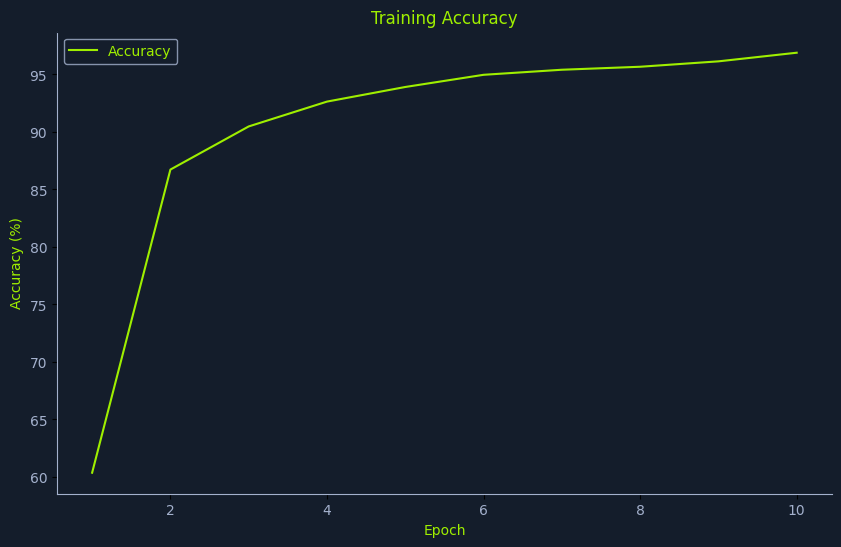

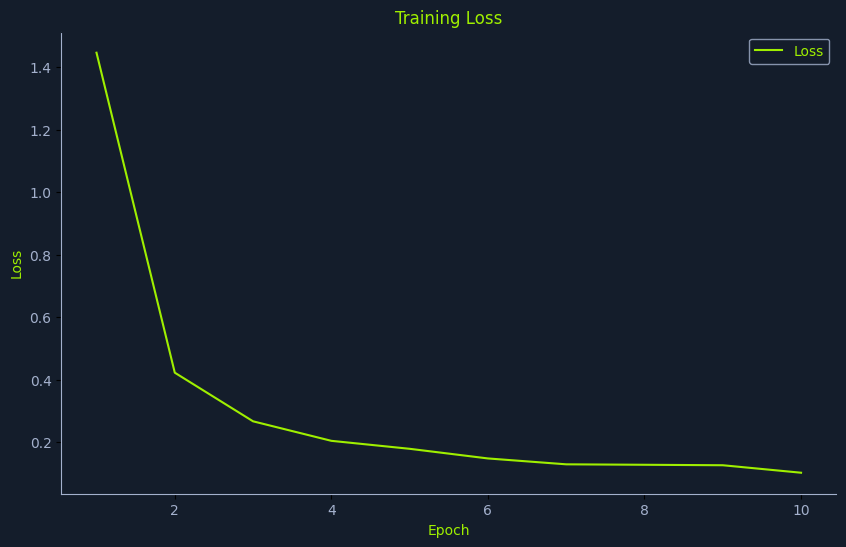

In [23]:
# data parameters
DATA_PATH = "./newdata/"

# training parameters
N_EPOCHS = 10
TRAINING_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1024

# model parameters
HIDDEN_LAYER_SIZE = 1000
MODEL_FILE = "malware_classifier.pth"


# Load datasets
train_loader, test_loader, n_classes = load_datasets(DATA_PATH, TRAINING_BATCH_SIZE, TEST_BATCH_SIZE)

# Initialize model
model = MalwareClassifier(n_classes)

# Train model
print("[i] Starting Training...")  
training_information = train(model, train_loader, N_EPOCHS, verbose=True)

# Save model
save_model(model, MODEL_FILE)

# evaluate model
accuracy = evaluate(model, test_loader)
print(f"[i] Inference accuracy: {accuracy}%.")  

# Plot training details
plot_training_accuracy(training_information)
plot_training_loss(training_information)

In [26]:
import joblib

# Save the trained model to a file for future use
model_filename = 'malware_classification.joblib'
joblib.dump(save_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to malware_classification.joblib
